# Parkinson's Disease Detection

### Importing Necesory Libraries

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import numpy as np
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd # Make sure to import pandas for the confusion matrix

## Data Loading and Preprocessing

In [6]:
# --- 1. Data Loading ---
# (This part remains the same)
data_train = np.load('Dataset_2/train_set.npz', allow_pickle=True)
x_train_np = data_train['arr_0']
y_train_np = data_train['arr_1']

data_test = np.load('Dataset_2/test_set.npz', allow_pickle=True)
x_test_np = data_test['arr_0']
y_test_np = data_test['arr_1']


In [7]:
# --- 2. Data Augmentation and Preprocessing (Corrected) ---

# Define transformations for data augmentation ONLY
# Note: ToTensor is included to work with PIL images, but we'll convert back to numpy
aug_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(360),
    transforms.ToTensor()
])

# --- Augment Training Data ---
x_aug_train = []
y_aug_train = []
for img, label in zip(x_train_np, y_train_np):
    for _ in range(70): # Create 70 augmented versions
        aug_img_tensor = aug_transform(img)
        # Permute tensor from (C, H, W) to (H, W, C) and convert to numpy
        aug_img_np = aug_img_tensor.permute(1, 2, 0).numpy() * 255
        x_aug_train.append(aug_img_np.astype(np.uint8))
        y_aug_train.append(label)

# --- Augment Test Data ---
x_aug_test = []
y_aug_test = []
for img, label in zip(x_test_np, y_test_np):
    for _ in range(20): # Create 20 augmented versions
        aug_img_tensor = aug_transform(img)
        aug_img_np = aug_img_tensor.permute(1, 2, 0).numpy() * 255
        x_aug_test.append(aug_img_np.astype(np.uint8))
        y_aug_test.append(label)

# --- Combine original and augmented data ---
x_train_combined = np.concatenate((x_train_np, np.array(x_aug_train)))
y_train_combined = np.concatenate((y_train_np, np.array(y_aug_train)))
x_test_combined = np.concatenate((x_test_np, np.array(x_aug_test)))
y_test_combined = np.concatenate((y_test_np, np.array(y_aug_test)))

# --- Preprocess ALL images uniformly ---
def preprocess_all(images):
    processed_images = []
    for img in images:
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        processed_images.append(img)
    return np.array(processed_images)

x_train_processed = preprocess_all(x_train_combined)
x_test_processed = preprocess_all(x_test_combined)

# --- Normalize and Encode Labels ---
x_train = x_train_processed / 255.0
x_test = x_test_processed / 255.0

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train_combined)
y_test = label_encoder.transform(y_test_combined)

# --- Convert to PyTorch Tensors and create DataLoaders ---
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1) # Add channel dimension
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# The rest of your code (Model Definition, Training, Evaluation) remains the same.

## Data Visualization

Total training images: 72
Number of Healthy images: 0
Number of Parkinson's images: 0


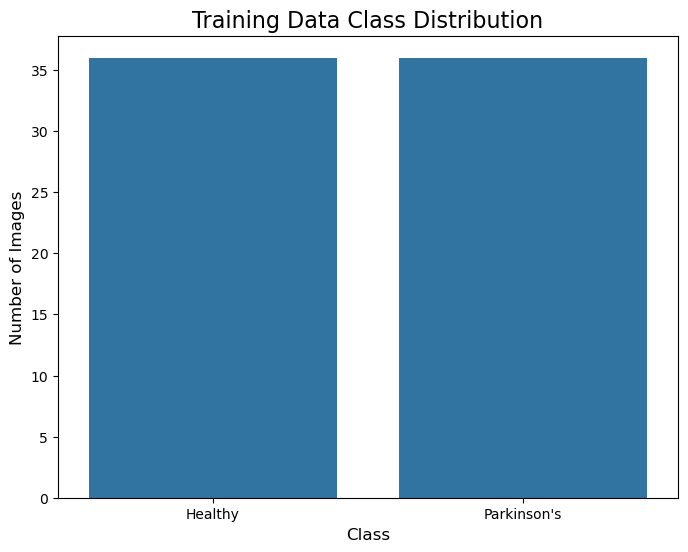

In [64]:
num_images = len(x_train_np)
num_healthy = np.sum(y_train_np == 0)
num_parkinsons = np.sum(y_train_np == 1)

print(f"Total training images: {num_images}")
print(f"Number of Healthy images: {num_healthy}")
print(f"Number of Parkinson's images: {num_parkinsons}")


# --- Visualization 1: Class Distribution Bar Chart ---
# A bar chart is the clearest way to see the balance between classes.
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_np)
plt.title('Training Data Class Distribution', fontsize=16)
plt.ylabel('Number of Images', fontsize=12)
plt.xlabel('Class', fontsize=12)
# Set custom labels for the x-axis for clarity
plt.xticks(ticks=[0, 1], labels=['Healthy', 'Parkinson\'s'])
plt.show()

--- Dataset Label Diagnosis ---
Found unique labels: ['healthy' 'parkinson']
Counts for each label: [36 36]
---------------------------------


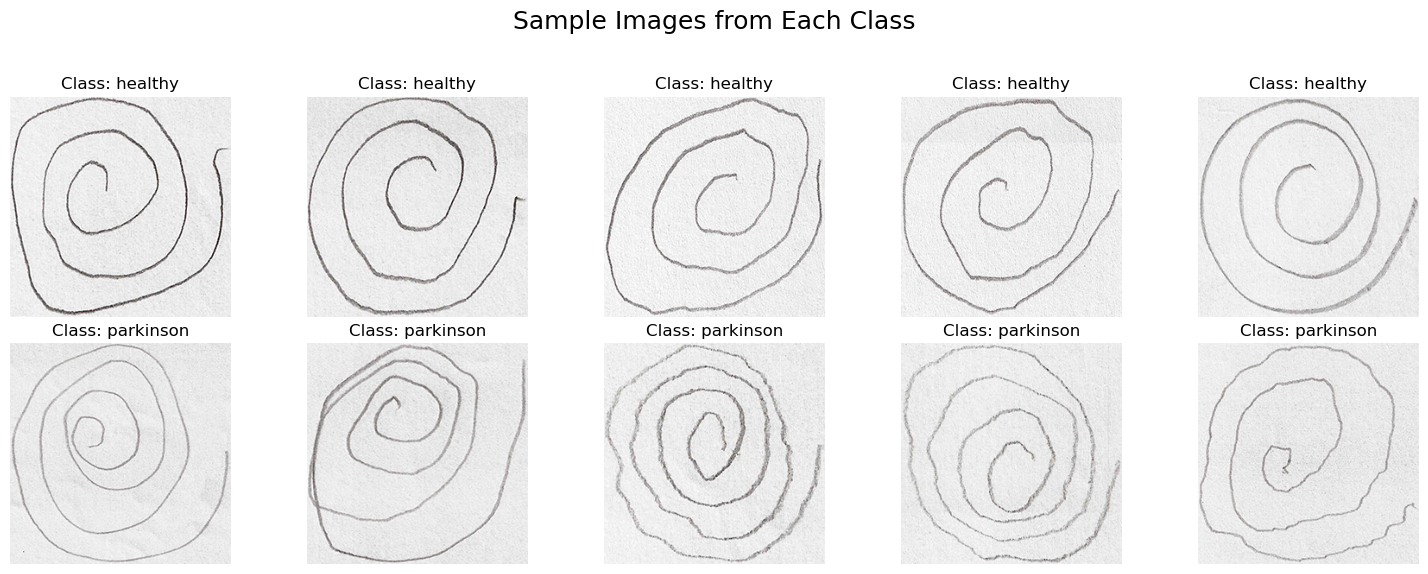

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# --- Step 1: Diagnose the Labels ---
unique_labels, counts = np.unique(y_train_np, return_counts=True)
print("--- Dataset Label Diagnosis ---")
print(f"Found unique labels: {unique_labels}")
print(f"Counts for each label: {counts}")
print("---------------------------------")

# --- Step 2: Safely Visualize the Data ---
# We will assume the two labels are the first two unique ones found.
# IMPORTANT: You may need to adjust the labels here based on the output above.
label_one = unique_labels[0]
label_two = unique_labels[1]

label_one_name = f"Class: {label_one}"
label_two_name = f"Class: {label_two}"

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Sample Images from Each Class', fontsize=18)

# Safely get indices for each class
class_one_indices = np.where(y_train_np == label_one)[0]
class_two_indices = np.where(y_train_np == label_two)[0]

# Plot 5 sample images for the first class
if len(class_one_indices) > 0:
    for i in range(min(5, len(class_one_indices))):
        ax = axs[0, i]
        ax.imshow(x_train_np[class_one_indices[i]], cmap='gray')
        ax.set_title(label_one_name)
        ax.axis('off')
else:
    print(f"Warning: No images found for '{label_one_name}'.")

# Plot 5 sample images for the second class
if len(class_two_indices) > 0:
    for i in range(min(5, len(class_two_indices))):
        ax = axs[1, i]
        ax.imshow(x_train_np[class_two_indices[i]], cmap='gray')
        ax.set_title(label_two_name)
        ax.axis('off')
else:
    print(f"Warning: No images found for '{label_two_name}'.")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

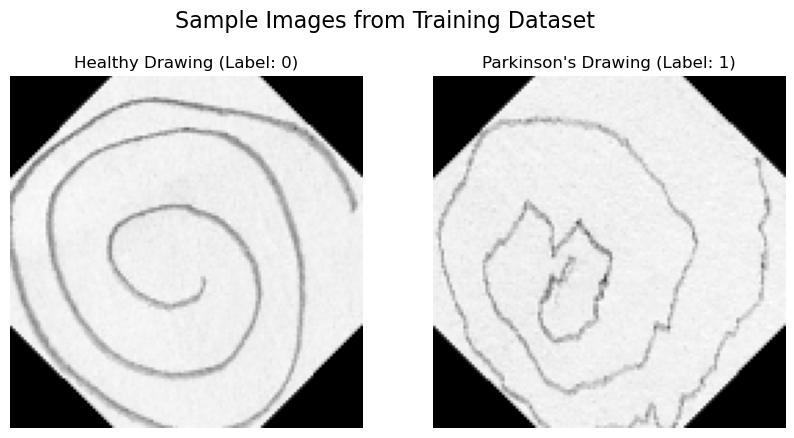

In [66]:
# Create a figure to display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Sample Images from Training Dataset', fontsize=16)

# Display the 'Healthy' sample if found
if healthy_sample is not None:
    # Convert from (C, H, W) tensor to (H, W, C) for plotting
    healthy_img = healthy_sample.squeeze().cpu().numpy()
    ax1.imshow(healthy_img, cmap='gray')
    ax1.set_title("Healthy Drawing (Label: 0)", fontsize=12)
    ax1.axis('off')
else:
    ax1.set_title("Healthy Sample Not Found", fontsize=12)
    ax1.axis('off')


# Display the 'Parkinson's' sample if found
if parkinson_sample is not None:
    # Convert from (C, H, W) tensor to (H, W, C) for plotting
    parkinson_img = parkinson_sample.squeeze().cpu().numpy()
    ax2.imshow(parkinson_img, cmap='gray')
    ax2.set_title("Parkinson's Drawing (Label: 1)", fontsize=12)
    ax2.axis('off')
else:
    ax2.set_title("Parkinson's Sample Not Found", fontsize=12)
    ax2.axis('off')

# Show the plot
plt.show()

Attempting to create pixel intensity histograms...


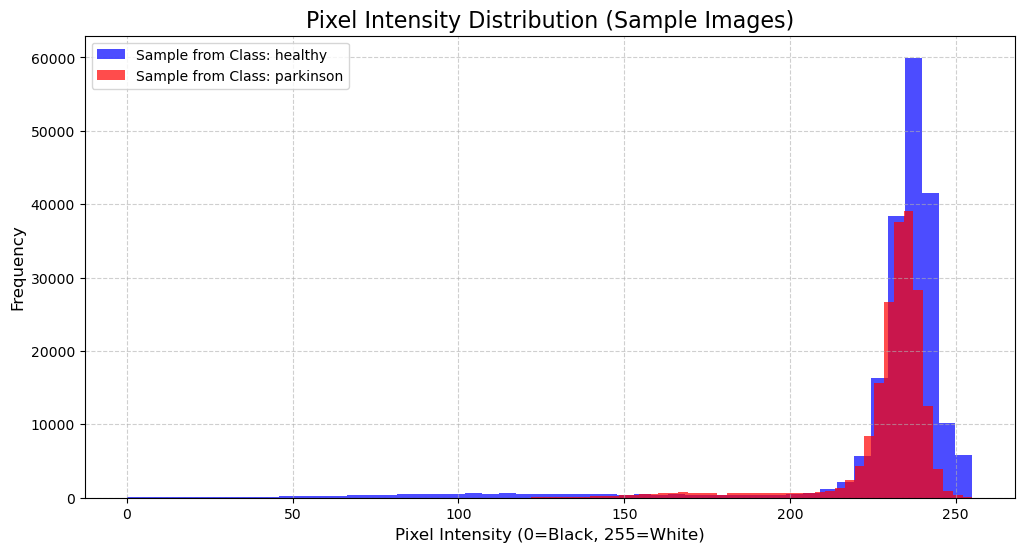

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# --- Safely plot pixel intensity distribution ---
print("Attempting to create pixel intensity histograms...")

# Get the unique labels from your training data
unique_labels_in_data = np.unique(y_train_np)

# Check if there are at least two classes to compare
if len(unique_labels_in_data) < 2:
    print("Warning: Cannot compare histograms because only one class was found in the dataset.")
else:
    # Assuming the first two unique labels are the ones to compare
    class_one_label = unique_labels_in_data[0]
    class_two_label = unique_labels_in_data[1]

    # Safely get indices for each class
    class_one_indices = np.where(y_train_np == class_one_label)[0]
    class_two_indices = np.where(y_train_np == class_two_label)[0]

    # Proceed only if both classes have images
    if len(class_one_indices) > 0 and len(class_two_indices) > 0:
        plt.figure(figsize=(12, 6))

        # Plot histogram for a sample image from the first class
        plt.hist(x_train_np[class_one_indices[0]].flatten(), bins=50, color='blue', alpha=0.7, label=f'Sample from Class: {class_one_label}')

        # Plot histogram for a sample image from the second class
        plt.hist(x_train_np[class_two_indices[0]].flatten(), bins=50, color='red', alpha=0.7, label=f'Sample from Class: {class_two_label}')

        plt.title('Pixel Intensity Distribution (Sample Images)', fontsize=16)
        plt.xlabel('Pixel Intensity (0=Black, 255=White)', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()
    else:
        print("Warning: Could not plot histograms because at least one class has no sample images.")

## Defining Model

In [8]:
# --- 3. Model Definition ---
class ParkinsonDetectionModel(nn.Module):
    def __init__(self):
        super(ParkinsonDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=9, stride=3)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, stride=1, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)
        
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.pool4(x)
        
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

## Model Training

In [9]:
# --- 4. Training ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using: ", device)

model = ParkinsonDetectionModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3.15e-5, weight_decay=0.001)

history = {'accuracy': [], 'val_accuracy': [], 'loss': [], 'val_loss': []}

epochs = 70
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    history['loss'].append(train_loss)
    history['accuracy'].append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    val_loss /= len(test_loader)
    val_acc = 100 * correct / total
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    print(f"Epoch {epoch+1}/{epochs} - Loss: {train_loss:.4f}, "
          f"Accuracy: {train_acc:.2f}%, Val_Loss: {val_loss:.4f}, "
          f"Val_Accuracy: {val_acc:.2f}%")

# --- Save trained model ---
model_path = "parkinson_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Using:  cuda
Epoch 1/70 - Loss: 0.6945, Accuracy: 49.47%, Val_Loss: 0.6937, Val_Accuracy: 50.00%
Epoch 2/70 - Loss: 0.6938, Accuracy: 50.18%, Val_Loss: 0.6932, Val_Accuracy: 50.00%
Epoch 3/70 - Loss: 0.6937, Accuracy: 50.08%, Val_Loss: 0.6930, Val_Accuracy: 50.00%
Epoch 4/70 - Loss: 0.6939, Accuracy: 49.18%, Val_Loss: 0.6931, Val_Accuracy: 50.00%
Epoch 5/70 - Loss: 0.6934, Accuracy: 50.04%, Val_Loss: 0.6930, Val_Accuracy: 50.00%
Epoch 6/70 - Loss: 0.6932, Accuracy: 50.82%, Val_Loss: 0.6930, Val_Accuracy: 50.00%
Epoch 7/70 - Loss: 0.6942, Accuracy: 49.53%, Val_Loss: 0.6930, Val_Accuracy: 50.00%
Epoch 8/70 - Loss: 0.6936, Accuracy: 50.45%, Val_Loss: 0.6930, Val_Accuracy: 50.00%
Epoch 9/70 - Loss: 0.6932, Accuracy: 50.55%, Val_Loss: 0.6926, Val_Accuracy: 63.65%
Epoch 10/70 - Loss: 0.6943, Accuracy: 48.65%, Val_Loss: 0.6927, Val_Accuracy: 52.06%
Epoch 11/70 - Loss: 0.6935, Accuracy: 50.45%, Val_Loss: 0.6926, Val_Accuracy: 52.06%
Epoch 12/70 - Loss: 0.6931, Accuracy: 50.94%, Val_Loss: 0.692

## Model Evaluation

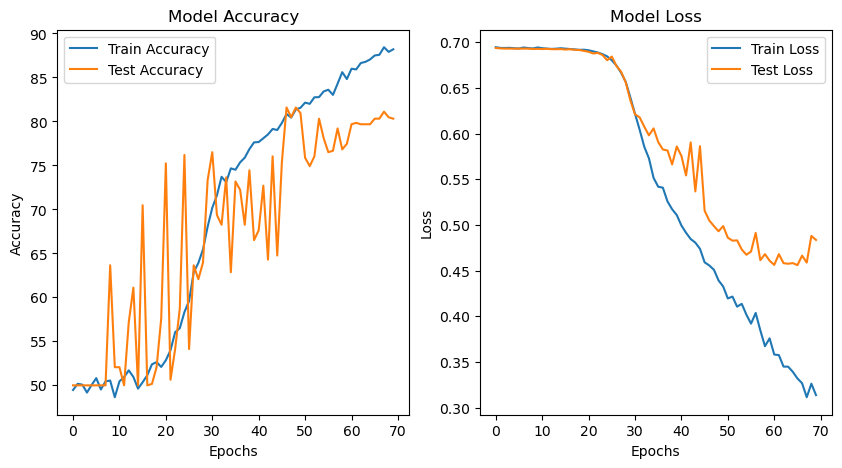

In [10]:
# --- 5. Evaluation ---
# Loss and Accuracy Plots
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       0.84      0.75      0.79       315
           1       0.77      0.86      0.81       315

    accuracy                           0.80       630
   macro avg       0.81      0.80      0.80       630
weighted avg       0.81      0.80      0.80       630



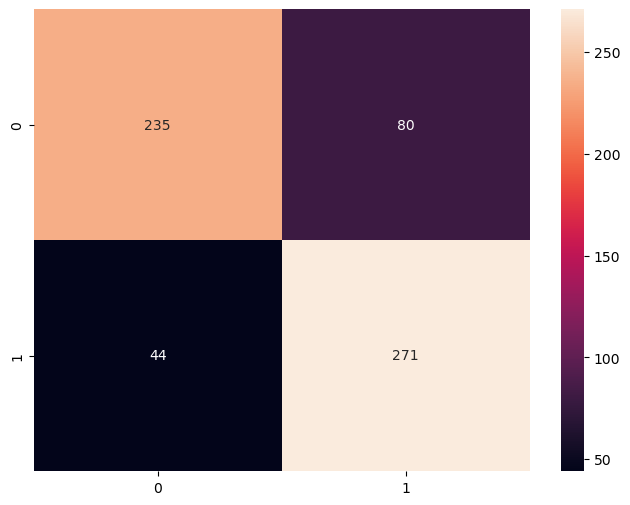

In [67]:
# Classification Report and Confusion Matrix
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds))

matrix = confusion_matrix(all_labels, all_preds)
df_cm = pd.DataFrame(matrix, index=[0, 1], columns=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

# Explainable AI Techniques

## Importing Necessary Libraries and Creating Helper Classes

In [17]:
# --- XAI Library Imports ---
print("Importing libraries for Explainable AI...")

# For Integrated Gradients and Occlusion Sensitivity
from captum.attr import (
    IntegratedGradients,
    Occlusion,
    visualization as viz
)

# For LIME
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries

# For SHAP
import shap

# --- Helper Class for Grad-CAM & Grad-CAM++ ---
# This class captures the gradients and activations from the model's layers,
# which are necessary for both Grad-CAM and Grad-CAM++.
class GradCamHelper:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        # Register hooks to the target layer
        self.target_layer.register_forward_hook(self._forward_hook)
        self.target_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, index=None, use_plusplus=False):
        output = self.model(x)
        if index is None:
            index = torch.argmax(output, dim=1).item()

        target = output[0][index]
        self.model.zero_grad()
        # retain_graph=True is important for running multiple XAI methods
        target.backward(retain_graph=True)

        if use_plusplus:
            # Grad-CAM++ specific logic
            grad_2 = self.gradients.pow(2)
            grad_3 = self.gradients.pow(3)
            alpha_num = grad_2
            alpha_den = 2 * grad_2 + (self.activations * grad_3).sum(dim=(2, 3), keepdim=True)
            alpha_den[alpha_den == 0.0] = 1e-7 # Avoid division by zero
            alpha = alpha_num / alpha_den
            weights = (alpha * nn.ReLU()(self.gradients)).sum(dim=(2, 3), keepdim=True)
        else:
            # Standard Grad-CAM
            weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        
        # Generate heatmap
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)
        cam = nn.ReLU()(cam) # Apply ReLU
        
        # Normalize for visualization
        cam -= torch.min(cam)
        cam /= torch.max(cam)
        return cam.cpu().numpy()

print("✅ XAI libraries and helper classes are ready.")

Importing libraries for Explainable AI...


C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ XAI libraries and helper classes are ready.


## Making Model Ready For Evaluation and Choosing a Random Sample Test Image

Selected a sample image for explanation.
True Label:      Parkinson
Predicted Label: Parkinson


C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


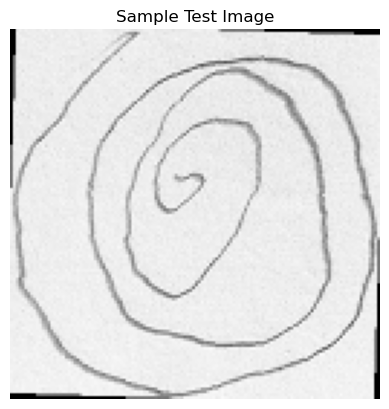

In [19]:
# Set model to evaluation mode
model.eval()

# Get a random sample image and its label from the test set
input_tensor, label = test_dataset[random.randint(0, len(test_dataset)-1)]
# Add a batch dimension and send the tensor to the correct device
input_tensor = input_tensor.unsqueeze(0).to(device)

# --- You can also pick a specific image if you prefer ---
# For example, to get the 10th image in the test set:
# input_tensor, label = test_dataset[10]
# input_tensor = input_tensor.unsqueeze(0).to(DEVICE)


# Create a version of the image that can be displayed by matplotlib
original_img_for_display = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

# Get the model's prediction for this image
output = model(input_tensor)
_, prediction_score = torch.max(output, 1)
predicted_label = prediction_score.item()

print(f"Selected a sample image for explanation.")
print(f"True Label:      {'Parkinson' if label else 'Healthy'}")
print(f"Predicted Label: {'Parkinson' if predicted_label else 'Healthy'}")

# Display the selected image
plt.imshow(original_img_for_display, cmap='gray')
plt.axis('off')
plt.title("Sample Test Image")
plt.show()

## 1: Integrated Gradients

C:\Users\Reach\anaconda3\envs\pytorch_env\Lib\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Integrated Gradients Calculated.


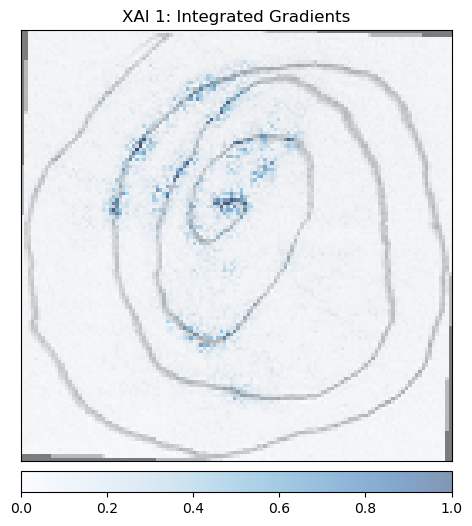

In [23]:
# 1. Integrated Gradients
ig = IntegratedGradients(model)
ig_attr = ig.attribute(input_tensor, target=predicted_label, n_steps=100)
ig_attr_2d = ig_attr.squeeze().cpu().detach().numpy()

# --- FINAL FIX ---
# The visualization function expects a 3D array (H, W, C).
# We need to add a channel dimension to our 2D attribution map.
ig_attr_viz = np.expand_dims(ig_attr_2d, axis=2)

print("Integrated Gradients Calculated.")

# Visualize the results
fig, _ = viz.visualize_image_attr(
    ig_attr_viz,
    original_img_for_display,
    method="blended_heat_map",
    sign="absolute_value",
    show_colorbar=True,
    title="XAI 1: Integrated Gradients"
)

## 2: Grad-Cam

Grad-CAM Calculated.


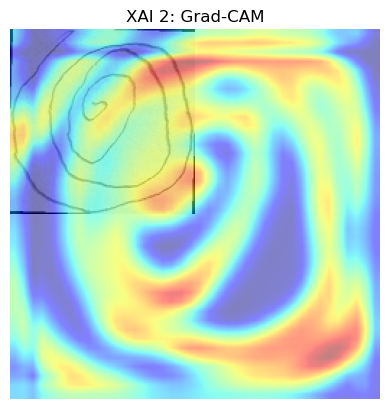

In [25]:
# --- FIX: Define the image size ---
# Make sure this matches the size you used for training.
IMG_SIZE = 256

# 2. Grad-CAM
# Target the final convolutional layer of your model
grad_cam = GradCamHelper(model, model.conv2)
# Generate the heatmap
cam_map = grad_cam(input_tensor, index=predicted_label)
# Resize heatmap to match the original image size
cam_resized = cv2.resize(cam_map, (IMG_SIZE, IMG_SIZE))

print("Grad-CAM Calculated.")

# Visualize the heatmap overlayed on the original image
plt.imshow(original_img_for_display, cmap='gray')
plt.imshow(cam_resized, cmap='jet', alpha=0.5) # alpha makes the heatmap transparent
plt.title("XAI 2: Grad-CAM")
plt.axis('off')
plt.show()

## 3: Grad-Cam++

Grad-CAM++ Calculated.


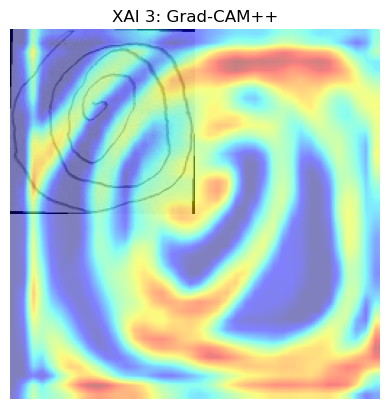

In [26]:
# Helper class for Grad-CAM++
class GradCamPlusPlusHelper(GradCamHelper): # Inherits from our previous helper
    def __call__(self, x, index=None):
        output = self.model(x)
        if index is None:
            index = np.argmax(output.cpu().data.numpy())

        target = output[0][index]
        self.model.zero_grad()
        target.backward(retain_graph=True)

        # Grad-CAM++ specific logic
        grad_2 = self.gradients.pow(2)
        grad_3 = self.gradients.pow(3)
        alpha_num = grad_2
        alpha_den = 2 * grad_2 + (self.activations * grad_3).sum(dim=(2, 3), keepdim=True)
        # Avoid division by zero
        alpha_den[alpha_den == 0.0] = 1e-7
        alpha = alpha_num / alpha_den

        weights = (alpha * nn.ReLU()(self.gradients)).sum(dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1).squeeze(0)
        
        cam = nn.ReLU()(cam) # Apply ReLU
        cam -= torch.min(cam) # Normalize
        cam /= torch.max(cam)
        return cam.cpu().detach().numpy()

# 3. Grad-CAM++
grad_cam_plus = GradCamPlusPlusHelper(model, model.conv2)
cam_plus_map = grad_cam_plus(input_tensor, index=predicted_label)
cam_plus_resized = cv2.resize(cam_plus_map, (IMG_SIZE, IMG_SIZE))

print("Grad-CAM++ Calculated.")

plt.imshow(original_img_for_display, cmap='gray')
plt.imshow(cam_plus_resized, cmap='jet', alpha=0.5)
plt.title("XAI 3: Grad-CAM++")
plt.axis('off')
plt.show()

## 4: Occlusion Senstivity

Occlusion Sensitivity Calculated.


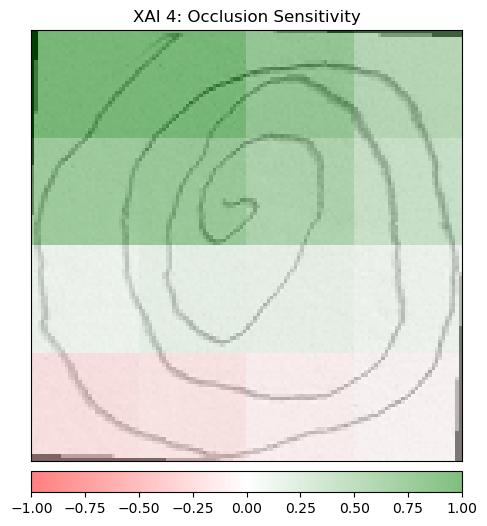

In [29]:
# 4. Occlusion Sensitivity
occlusion = Occlusion(model)
occ_attr = occlusion.attribute(
    input_tensor,
    strides=(1, 32, 32),
    target=predicted_label,
    sliding_window_shapes=(1, 64, 64)
)
occ_attr_2d = occ_attr.squeeze().cpu().detach().numpy()

# --- FINAL FIX ---
# The same fix applies here. Add a channel dimension for the visualizer.
occ_attr_viz = np.expand_dims(occ_attr_2d, axis=2)

print("Occlusion Sensitivity Calculated.")

# Visualize the results
fig, _ = viz.visualize_image_attr(
    occ_attr_viz,
    original_img_for_display,
    method="blended_heat_map",
    sign="all",
    show_colorbar=True,
    title="XAI 4: Occlusion Sensitivity"
)

## 5: Lime

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]C:\Users\Reach\AppData\Local\Temp\ipykernel_5144\2168594678.py:63: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_img = Image.fromarray(img.astype('uint8'), 'RGB')
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.62it/s]


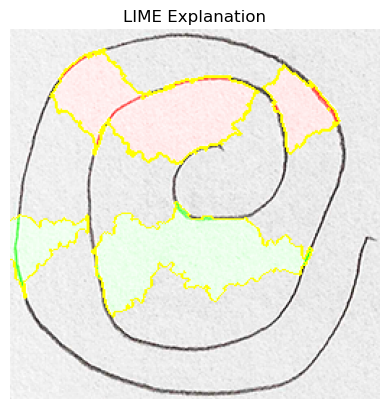

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# 1️⃣ Exact architecture from your print(model)
class ParkinsonDetectionModel(nn.Module):
    def __init__(self):
        super(ParkinsonDetectionModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=5, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=9, stride=3)
        self.conv2 = nn.Conv2d(128, 64, kernel_size=5, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=7, stride=3)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding='same')
        self.pool3 = nn.MaxPool2d(kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(32, 32, kernel_size=3, padding='same')
        self.pool4 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.flatten = nn.Flatten()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc1 = nn.Linear(32, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.relu(self.conv3(x))
        x = self.pool3(x)
        x = self.relu(self.conv4(x))
        x = self.pool4(x)
        x = self.flatten(x)
        x = self.dropout1(x)
        x = self.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

# 2️⃣ Load model with safe weights loading
model = ParkinsonDetectionModel()
state_dict = torch.load("parkinson_model.pth", map_location="cpu", weights_only=True)
model.load_state_dict(state_dict)
model.eval()

# 3️⃣ Transform for single-channel input
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((128, 128)),  # Match training size
    transforms.ToTensor()
])

# 4️⃣ Prediction function for LIME
def predict_fn(images):
    batch = []
    for img in images:
        pil_img = Image.fromarray(img.astype('uint8'), 'RGB')
        img_tensor = transform(pil_img).unsqueeze(0)
        batch.append(img_tensor)
    batch = torch.cat(batch)
    with torch.no_grad():
        outputs = model(batch)
        probs = torch.softmax(outputs, dim=1).numpy()
    return probs

# 5️⃣ Load a sample image
img_path = "test_image.png"  # Replace with your image path
image = Image.open(img_path).convert("RGB")
image_np = np.array(image)

# 6️⃣ Run LIME
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(
    image_np,
    predict_fn,
    top_labels=1,
    hide_color=0,
    num_samples=1000
)

# 7️⃣ Visualize explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=False,
    hide_rest=False,
    num_features=10,
    min_weight=0.01
)

plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title("LIME Explanation")
plt.axis('off')
plt.show()

## 6: Gradient SHAP

Setting up Gradient SHAP...
Gradient SHAP Values Calculated.
Generating SHAP plot...


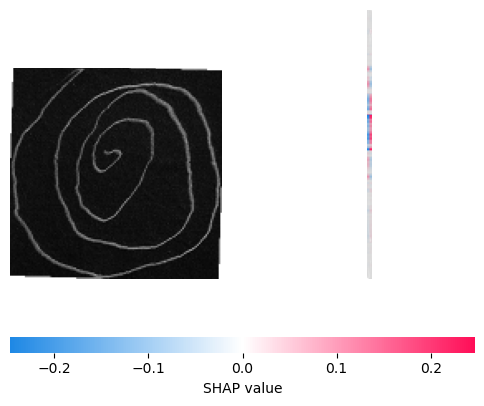

In [43]:
# 6. Gradient SHAP
print("Setting up Gradient SHAP...")

# SHAP needs a background dataset to compute expectations.
# We'll use a small subset of the test set.
background_data = torch.stack([test_dataset[i][0] for i in range(20)]).to(device)

# Initialize the SHAP explainer
e = shap.GradientExplainer(model, background_data)
# Calculate SHAP values for our sample image
shap_values = e.shap_values(input_tensor)

print("Gradient SHAP Values Calculated.")

# --- FINAL FIX ---
# The shap.image_plot function is designed to handle the output directly.
# We just need to reorder the dimensions of the tensors from (B, C, H, W)
# to what the plot function expects: (B, H, W, C).

# 1. Transpose the SHAP values
transposed_shap_values = [np.transpose(v, (0, 2, 3, 1)) for v in shap_values]

# 2. Transpose the original image tensor
transposed_pixel_values = np.transpose(input_tensor.cpu().numpy(), (0, 2, 3, 1))


# Visualize the result using SHAP's plotting library
print("Generating SHAP plot...")
shap.image_plot(
    transposed_shap_values,
    -transposed_pixel_values, # Use negative for aesthetic reasons in the plot
    show=True
)
# Note: Red pixels increase the prediction score towards the predicted class,
# while blue pixels decrease it.